## Remmember: This may be used for NON comercial uses.

In [1]:
import _pickle as cPickle
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

### globals

In [2]:
FN = 'embedding'
seed = 42 #the answer to the question. 
vocab_size = 40000
embedding_dim = 100
lower = False #don't lower case the text
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

### Read tokenized headlines and descriptions.

In [3]:
FN0 = 'vocab-embedding' # File from the dataset
with open('data/{}.pkl'.format(FN0),'rb') as fp:
    heads, desc = cPickle.load(fp)# keywords are not used in this project

In [4]:
if lower:
    heads = [h.lower() for h in heads]
    desc = [h.lower() for h in desc]
    
i = 0
heads[i]

'Worcester breakfast club for veterans gives hunger its marching orders'

In [5]:
desc[i]

'VETERANS saluted Worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. \n \nThe Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday. \n \nThe club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. \n \nFather-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country. \n \nHe said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up. \n \n"We even had an old chap travel from Droitwich and he was late on parade by three hours. \n \n"It\'s generated a lot of interest and I estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. Onwards and upwards." \n \nHe said the management at the pub ha

In [6]:
len(heads),len(set(heads))

(1000000, 802209)

In [7]:
len(desc),len(set(desc))

(1000000, 882970)

### Build vocab

In [27]:
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(),key=lambda x: -x[1])))
    return vocab,vocabcount

In [28]:
vocab,vocabcount = get_vocab(heads+desc)

most popular tokens

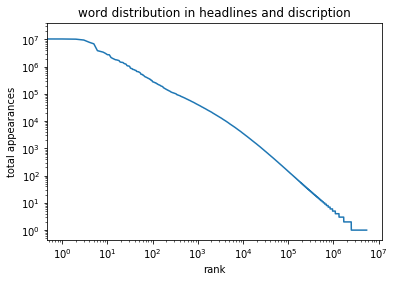

In [29]:
plt.plot([vocabcount[w] for w in vocab])
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

### Index words

In [30]:
def get_idx(vocab,vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    idx2word = dict((idx,word) for word,idx in word2idx.items())
    return word2idx,idx2word

In [31]:
word2idx,idx2word = get_idx(vocab,vocabcount)

In [13]:
vocab = None
vocabcount = None

### Embedding

In [14]:
fname = 'data/glove.6B.{}d.txt'.format(embedding_dim)
glove_n_symbols = !wc -l {fname}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
glove_index_dict = {}
globale_scale = .1
with open(fname,'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [15]:
glove_embedding_weights.std()


0.040815727600190289

In [16]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

### Embedding matrix

In [17]:
np.random.seed(seed)
shape = (vocab_size,embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale,high=scale,size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())
# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w,glove_index_dict.get(w.lower()))
    if g  is None and w.startswith('#'): #glove has no hashtags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w,glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514 std 0.0408138249575
number of tokens, in small vocab, found in glove and copied to embedding 27785 0.694625


lots of word in the full vocabulary (word2idx) are outside vocab_size. Build an alterantive which will map them to their closest match in glove but only if the match is good enough (cos distance above glove_thr)

In [18]:
glove_thr = 0.5
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix. Use cos distance of GloVe vectors.


Allow for the last nb_unknown_words words inside the embedding matrix to be considered to be outside. Dont accept distances below glove_thr

In [19]:
normed_embedding = embedding / np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]
nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        # TO-DO CORRECTLY
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key=lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))
        

# of glove substitutes found 241321


manually check that the worst substitutions we are going to do are good enough

In [20]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.500003799 MAIA => Joanna
0.500003799 maia => Joanna
0.50000375703 Clingmans => offeree
0.50000324986 Neurogenetics => mHealth
0.500002865621 Capsa => Astra
0.500002062784 Tesa => Fitbit
0.500002062784 TESA => Fitbit
0.500002062784 tesa => Fitbit
0.500000572386 Giao => Manjhi
0.500000572386 giao => Manjhi


build a lookup table of index of outside words to index of inside words

In [21]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

### Data

In [23]:
with open('data/{}.pkl'.format('pickledEmbs'),'wb') as fp:
    cPickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [24]:
embedding = None 
idx2word = None
glove_idx2idx = None

In [32]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

1000000

(array([  2.05020000e+04,   2.54100000e+04,   3.82240000e+04,
          6.05420000e+04,   8.48480000e+04,   1.05899000e+05,
          1.19528000e+05,   1.18175000e+05,   1.05438000e+05,
          8.47750000e+04,   1.11677000e+05,   3.36120000e+04,
          2.38460000e+04,   1.72670000e+04,   1.20770000e+04,
          8.93400000e+03,   6.25900000e+03,   4.66900000e+03,
          3.50100000e+03,   2.69800000e+03,   3.86700000e+03,
          1.30700000e+03,   1.08400000e+03,   7.39000000e+02,
          6.72000000e+02,   6.09000000e+02,   4.17000000e+02,
          3.67000000e+02,   2.92000000e+02,   2.28000000e+02,
          4.23000000e+02,   2.16000000e+02,   2.44000000e+02,
          2.11000000e+02,   1.84000000e+02,   1.74000000e+02,
          1.99000000e+02,   2.03000000e+02,   1.54000000e+02,
          1.62000000e+02,   2.02000000e+02,   6.20000000e+01,
          4.30000000e+01,   2.00000000e+01,   1.60000000e+01,
          1.10000000e+01,   9.00000000e+00,   0.00000000e+00,
        

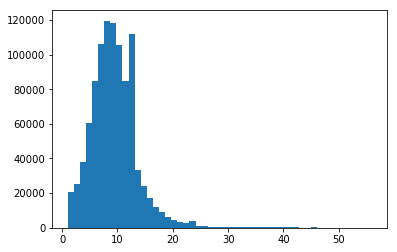

In [33]:
plt.hist(list(map(len,Y)),bins=50)

In [34]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

1000000

(array([  4.44128000e+05,   2.83433000e+05,   1.51130000e+05,
          6.63310000e+04,   2.48120000e+04,   1.11700000e+04,
          6.25800000e+03,   3.70900000e+03,   2.19400000e+03,
          1.43300000e+03,   1.11600000e+03,   8.09000000e+02,
          5.55000000e+02,   5.23000000e+02,   3.56000000e+02,
          2.99000000e+02,   2.40000000e+02,   2.07000000e+02,
          1.63000000e+02,   1.45000000e+02,   1.06000000e+02,
          8.70000000e+01,   7.50000000e+01,   5.60000000e+01,
          7.30000000e+01,   3.80000000e+01,   4.70000000e+01,
          3.20000000e+01,   4.70000000e+01,   3.30000000e+01,
          2.80000000e+01,   1.80000000e+01,   3.90000000e+01,
          2.50000000e+01,   1.90000000e+01,   2.20000000e+01,
          1.40000000e+01,   2.20000000e+01,   2.60000000e+01,
          3.50000000e+01,   2.70000000e+01,   2.60000000e+01,
          2.60000000e+01,   2.40000000e+01,   1.00000000e+01,
          1.10000000e+01,   1.00000000e+01,   1.00000000e+01,
        

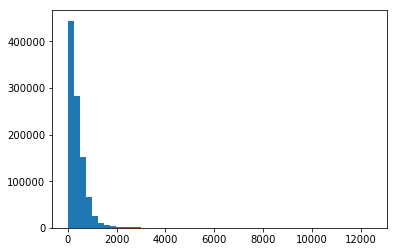

In [35]:
plt.hist(list(map(len,X)),bins=50)

In [38]:
with open('data/{}.data.pkl'.format('X-Y_values'),'wb') as fp:
    cPickle.dump((X,Y),fp,-1)

MemoryError: 